In [18]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
from pathlib import Path

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze => row vector -> column vector
y = weight * X + bias
X.shape, y.shape, X[:3], y[0:3]

(torch.Size([50, 1]),
 torch.Size([50, 1]),
 tensor([[0.0000],
         [0.0200],
         [0.0400]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280]]))

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([40, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [5]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [6]:
def plot_data_and_predictions(X_train, y_train, X_test, y_test, y_pred=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(4,4))
  plt.scatter(X_train, y_train, c="b", s=4, label="Training data")
  plt.scatter(X_test, y_test, c="g", s=4, label="Testing data")
  if y_pred is not None:
    plt.scatter(X_test, y_pred, c="r", s=4, label="Predictions")
  plt.legend(prop={"size": 14});

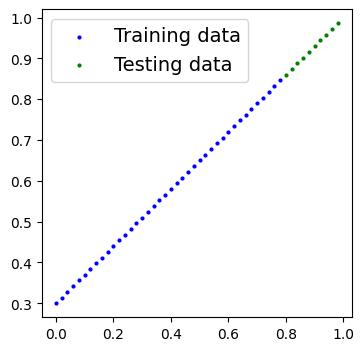

In [7]:
plot_data_and_predictions(X_train, y_train, X_test, y_test)

In [8]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [9]:
next(model.parameters()).device

device(type='cpu')

In [10]:
model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [11]:
# train and evaluate
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

epochs = 100

torch.manual_seed(42)
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)               # should be made on val data and not test data
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

/home/dorota/projects/Deep-Machine-Learning-Dorota-Bjoorn/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Train loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Train loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Train loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Train loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Train loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Train loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Train loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Train loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Train loss: 0.009653178043663502 | Test loss: 0.02167237363755703


In [16]:
print("The model learned the following values for weights and bias:")
pprint(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [13]:
# Make predictions on test data
model.eval()

with torch.inference_mode():
    y_pred = model(X_test)
y_pred

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]])

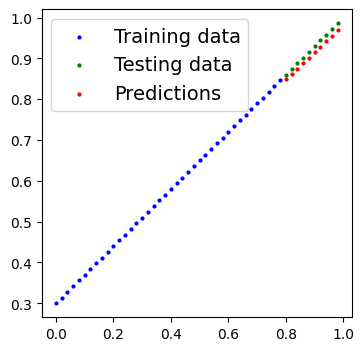

In [17]:
plot_data_and_predictions(X_train, y_train, X_test, y_test, y_pred.cpu())

In [19]:
# save model
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model.pth


In [21]:
# load model
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:cpu
